In [1]:
#eval PIPR on Fragoza pairs len <= 600 
#running PIPR from here, shell script will not detect CUDA devices 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import sys
if '../../embeddings' not in sys.path:
    sys.path.append('../../embeddings')

from seq2tensor import s2t
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, add
from keras.layers.core import Flatten, Reshape
from keras.layers.merge import Concatenate, concatenate, subtract, multiply
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D

from keras.optimizers import Adam, RMSprop

import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.2):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

import numpy as np
from tqdm import tqdm

from keras.layers import Input, CuDNNGRU
from numpy import linalg as LA
import scipy

Using TensorFlow backend.


In [2]:
# change
id2seq_file = './FragozaSequencesML600.tsv'

id2index = {}
seqs = []
index = 0
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1
seq_array = []
id2_aid = {}
sid = 0

seq_size = 600
emb_files = ['../../embeddings/default_onehot.txt', '../../embeddings/string_vec5.txt', '../../embeddings/CTCoding_onehot.txt', '../../embeddings/vec7_CTC.txt']
use_emb = 0
hidden_dim = 25
n_epochs=50

# ds_file, label_index, rst_file, use_emb, hidden_dim
ds_file = '../../yest/preprocessed/Supp-AB.tsv'
label_index = 2
rst_file = 'results/15k_onehot_cnn.txt'
sid1_index = 0
sid2_index = 1
'''
if len(sys.argv) > 1:
    ds_file, label_index, rst_file, use_emb, hidden_dim, n_epochs = sys.argv[1:]
    label_index = int(label_index)
    use_emb = int(use_emb)
    hidden_dim = int(hidden_dim)
    n_epochs = int(n_epochs)
'''
#manually set these for the three diff networks tested 
#../../../sun/preprocessed/Supp-AB.tsv -1 results/sun_wvctc_rcnn_25_5.txt 3 25 100
#../../../sun/preprocessed/Supp-AB.tsv -1 results/sun_wvctc_rcnn_50_5.txt 3 50 100
#../../../sun/preprocessed/Supp-AB.tsv -1 results/sun_wvctc_rcnn_75_5.txt 3 75 100
#best from the paper was hiden dim 50 
ds_file = "./mtFragozaPIPR.tsv"
label_index = -1
rst_file = "results/sun_wvctc_rcnn_50_5.txt"
use_emb = 3
hidden_dim = 50
n_epochs = 50
seq2t = s2t(emb_files[use_emb])

In [3]:


max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = True
x = None
count = 0

for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break
print (len(raw_data))


len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
print (avg_m_seq, max_m_seq)

dim = seq2t.dim
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

print(seq_index1[:10])

class_map = {'0':1,'1':0}
print(class_map)
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1.


1064it [00:00, 199871.89it/s]
 41%|████      | 432/1065 [00:00<00:00, 4309.50it/s]

1063
2 1


100%|██████████| 1063/1063 [00:00<00:00, 899988.93it/s]

[ 0  2  4  6  6  8 10 11 12 13]
{'0': 1, '1': 0}


In [4]:
modelName = "modelHiddenDims" + str(hidden_dim) + "fold0"
fold0PIPR =  keras.models.load_model(modelName)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [5]:
print (class_labels.shape)
test = np.array(list(range(0,len(class_labels))))
#print (testInds)

(1063, 2)


In [6]:
#load Fragoza data 
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.
fold = 0
pred = fold0PIPR.predict([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]]])
for i in range(len(class_labels[test])):
    num_total += 1
    if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[test][i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1
        else:
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1
accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)
mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
print (accuracy, prec, recall, spec, f1, mcc)



0.7450611476952023 0.8206229860365198 0.880184331797235 0.21212121212121213 0.849360755975542 0.021112203702259223


In [7]:
print (pred)


[[1.0000000e+00 3.0053610e-10]
 [1.0000000e+00 1.0533594e-08]
 [9.6786934e-01 3.2130618e-02]
 ...
 [9.9999976e-01 2.5332341e-07]
 [9.9990845e-01 9.1493377e-05]
 [9.9967754e-01 3.2246695e-04]]


In [8]:
print (num_true_pos)
print (num_false_pos)
print (num_true_neg)
print (num_false_neg)

#true is 868, 195
#making pr curve for one class? 
trueClass = pred[:,0]
print (trueClass)

print (class_labels[:,0])
print (np.unique(class_labels[:,0], return_counts=True))

#trying to make AUC ROC curve for proposal
trueOnesLabels = class_labels[:,0]
trueClass = pred[:,0]

#makde pandas df 
import pandas as pd
asDF = pd.DataFrame({'Disruptive':trueOnesLabels,'Score':trueClass})

print (asDF)
from sklearn import metrics




764.0
167.0
28.0
104.0
[1.         1.         0.96786934 ... 0.99999976 0.99990845 0.99967754]
[1. 1. 1. ... 1. 1. 1.]
(array([0., 1.]), array([195, 868]))
      Disruptive     Score
0            1.0  1.000000
1            1.0  1.000000
2            1.0  0.967869
3            0.0  0.999953
4            0.0  0.954582
5            1.0  0.005917
6            1.0  0.007786
7            1.0  0.004826
8            0.0  0.007742
9            1.0  0.983250
10           1.0  0.987249
11           1.0  0.983660
12           1.0  0.990448
13           1.0  0.000473
14           0.0  0.999998
15           1.0  0.999967
16           1.0  0.999936
17           0.0  0.999986
18           0.0  0.999989
19           1.0  0.999989
20           1.0  0.999983
21           0.0  0.999987
22           1.0  0.999998
23           1.0  0.999994
24           1.0  0.999999
25           1.0  0.999998
26           1.0  0.999997
27           0.0  0.999997
28           1.0  0.999999
29           1.0  0.999998
...    

In [9]:
#ROC curve 
import seaborn as sns 
fpr, tpr, thresholds = metrics.roc_curve(trueOnesLabels, trueClass)
#print (thresholds)
score = metrics.roc_auc_score(trueOnesLabels, trueClass)
sns.lineplot(x = fpr, y = tpr)

      Disruptive     Score                   Variant PPI Effect
0            1.0  1.000000      Disruptive Mutations \n (n=195)
1            1.0  1.000000      Disruptive Mutations \n (n=195)
2            1.0  0.967869      Disruptive Mutations \n (n=195)
3            0.0  0.999953  Non-disruptive Mutations \n (n=868)
4            0.0  0.954582  Non-disruptive Mutations \n (n=868)
5            1.0  0.005917      Disruptive Mutations \n (n=195)
6            1.0  0.007786      Disruptive Mutations \n (n=195)
7            1.0  0.004826      Disruptive Mutations \n (n=195)
8            0.0  0.007742  Non-disruptive Mutations \n (n=868)
9            1.0  0.983250      Disruptive Mutations \n (n=195)
10           1.0  0.987249      Disruptive Mutations \n (n=195)
11           1.0  0.983660      Disruptive Mutations \n (n=195)
12           1.0  0.990448      Disruptive Mutations \n (n=195)
13           1.0  0.000473      Disruptive Mutations \n (n=195)
14           0.0  0.999998  Non-disrupti

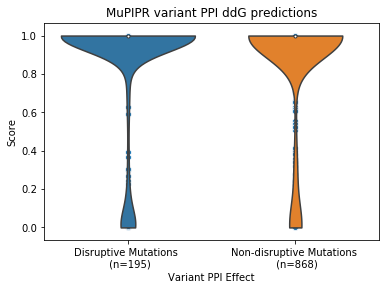

In [10]:
#scatter plot 
sns.scatterplot(x = 'Disruptive', y = 'Score', data =asDF )

def sortDis(val):
    if val == 1.0:
        return "Disruptive Mutations \n (n=195)"
    else:
        return "Non-disruptive Mutations \n (n=868)"
asDF['Variant PPI Effect'] = asDF.apply(lambda row: sortDis(row['Disruptive']), axis = 1)

print (asDF)
#violin plot 
ax = sns.violinplot(x="Variant PPI Effect", y="Score", data=asDF, cut = 0).set_title("MuPIPR variant PPI ddG predictions")
print (max(asDF['Score'].to_list()))

def classifier(score):
    if score >= 0.5:
        return 1
    else:
        return 0 
asDF['Predlabel'] = asDF.apply(lambda row: classifier(row['Score']), axis = 1)

    

[[ 28 167]
 [104 764]]


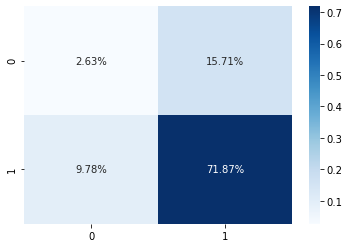

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#F
cf_matrix = metrics.confusion_matrix(asDF['Disruptive'], asDF['Predlabel'])
print(cf_matrix)
'''

764.0
167.0
28.0
104.0
'''
#sns.heatmap(cf_matrix, annot=True)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Text(0.5, 1, 'PIPR Prediction of PPI Disrupting Variants')

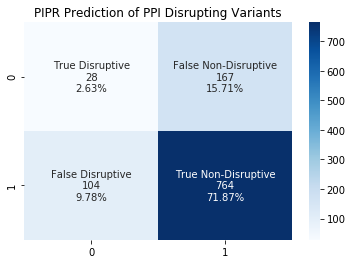

In [12]:
group_names = ['True Disruptive','False Non-Disruptive','False Disruptive','True Non-Disruptive']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues').set_title("PIPR Prediction of PPI Disrupting Variants")

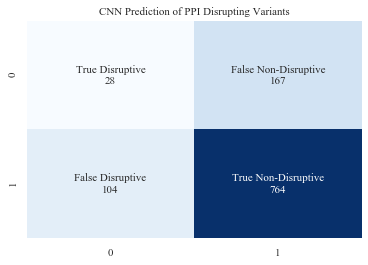

In [14]:
import matplotlib.pyplot as plt
sns.set(font="Times New Roman")
group_names = ['True Disruptive','False Non-Disruptive','False Disruptive','True Non-Disruptive']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 11}, fmt='', cbar = False, cmap='Blues').set_title("CNN Prediction of PPI Disrupting Variants", fontsize=11)
plt.savefig("piprNetworkTakeTwo.png", dpi=300)